<a href="https://colab.research.google.com/github/Trung0Minh/AIO2023-MODULE-3/blob/main/image_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
dataset_dir = 'images_mr'
image_filenames = os.listdir(dataset_dir)
src_images = []

for filename in image_filenames:
    filepath = os.path.join(dataset_dir, filename)
    print(filepath)
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    src_images.append(image)

images_mr/75.jpg
images_mr/123.jpg
images_mr/258.jpg
images_mr/128.jpg
images_mr/176.jpg
images_mr/292.jpg
images_mr/105.jpg
images_mr/295.jpg
images_mr/261.jpg
images_mr/4.jpg
images_mr/178.jpg
images_mr/238.jpg
images_mr/87.jpg
images_mr/233.jpg
images_mr/170.jpg
images_mr/121.jpg
images_mr/257.jpg
images_mr/227.jpg
images_mr/30.jpg
images_mr/113.jpg
images_mr/109.jpg
images_mr/166.jpg
images_mr/210.jpg
images_mr/58.jpg
images_mr/124.jpg
images_mr/285.jpg
images_mr/137.jpg
images_mr/136.jpg
images_mr/192.jpg
images_mr/248.jpg
images_mr/53.jpg
images_mr/220.jpg
images_mr/78.jpg
images_mr/61.jpg
images_mr/217.jpg
images_mr/11.jpg
images_mr/163.jpg
images_mr/296.jpg
images_mr/62.jpg
images_mr/70.jpg
images_mr/14.jpg
images_mr/99.jpg
images_mr/291.jpg
images_mr/252.jpg
images_mr/179.jpg
images_mr/232.jpg
images_mr/77.jpg
images_mr/138.jpg
images_mr/167.jpg
images_mr/183.jpg
images_mr/7.jpg
images_mr/199.jpg
images_mr/148.jpg
images_mr/299.jpg
images_mr/297.jpg
images_mr/206.jpg
images_mr

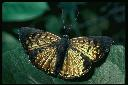

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(src_images[0])

In [ ]:
src_images[1].shape

(96, 128, 3)

In [ ]:
def image_resize(image, target_size=(64, 64)):
    return cv2.resize(image, target_size)

In [ ]:
def calculate_mean_std(images):
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))
    return mean, std

In [ ]:
def image_std_normalize(images, mean, std):
    return (images - mean) / std

In [ ]:
def image_flatten(images, is_batch=False):
    if is_batch:
        flattened_image = images.reshape(images.shape[0], -1)
    else:
        flattened_image = images.reshape(-1)
    return flattened_image

In [ ]:
def preprocess_images(images):
    resized_images = [image_resize(image) for images in images]
    images_arr = np.array(resized_images)
    mean, std = calculate_mean_std(images_arr)
    normalized_images = image_std_normalize(images_arr, mean, std)
    flattened_images = image_flatten(normalized_images, True)
    return flattened_images

In [ ]:
def preprocess_query(image):
    resized_image = image_resize(image)
    mean, std = calculate_mean_std(resized_image)
    normalized_image = image_std_normalize(resized_image, mean, std)
    flattened_image = image_flatten(normalized_image)
    return flattened_image

In [ ]:
def mean_absolute_error(query_vector, src_vectors):
    abs_diff = np.abs(src_vectors - query_vector)
    mae = np.mean(abs_diff, axis=1)
    return mae

def mean_squared_error(query_vector, src_vectors):
    squared_diff = (src_vectors - query_vector) ** 2
    mse = np.mean(squared_diff, axis=1)
    return mse

def cosine_similarity(query_vector, src_vectors):
    query_norm = np.linalg.norm(query_vector)
    normalized_query = query_vector / query_norm
    src_norms = np.linalg.norm(src_vectors, axis=1)
    normalized_src = src_vectors / src_norms[:, np.newaxis]
    cosine_similarity = np.dot(normalized_src, normalized_query)
    return cosine_similarity

def correlation_coefficient(query_vector, src_vectors):
    return np.corrcoef(query_vector, src_vectors)[:-1, -1]

In [ ]:
def ranking(preprocessed_query_image, preprocessed_src_images, top_k=10):
    scores = cosine_similarity(preprocessed_query_image, preprocessed_src_images)
    ranked_list = np.argsort(scores)[::-1][:top_k]
    scores = scores[ranked_list]
    return ranked_list, scores

In [ ]:
import random

query_image_path = random.choice(image_filenames)
query_image = cv2.imread(os.path.join(dataset_dir, query_image_path), 1)
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
preprocessed_query_image = preprocess_query(query_image)
preprocessed_src_images = preprocess_images(src_images)

top_k = 10
ranked_list, scores = ranking(preprocessed_query_image, preprocessed_src_images, top_k)
print('Query Image')
plt.figure(figsize=(3, 3))
plt.imshow(query_image)
plt.axis('off')
plt.show()

print(f'Top {top_k} results')
for idx in range(len(ranked_list)):
    src_image_idx = ranked_list[idx]
    similarity_score = scores[idx]
    plt.figure(figsize=(3, 3))
    plt.imshow(src_images[src_image_idx])
    plt.title(f"Similarity: {similarity_score}", fontsize=10)
    plt.axis('off')
    plt.show()

## Vision Transformer

In [ ]:
import torch
from transformers import ViTImageProcessor, ViTForImageClassification

In [ ]:
dataset_dir = 'images_mr'
image_filenames = os.listdir(dataset_dir)[:500]
src_images = []

for filename in image_filenames:
    filepath = os.path.join(dataset_dir, filename)
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    src_images.append(image)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Tải bộ xử lý ảnh (processor) từ mô hình Vision Transformer (ViT) đã được huấn luyện trước
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Tải mô hình phân loại ảnh từ mô hình Vision Transformer (ViT) đã được huấn luyện trước
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
def preprocessing(images):
    # Sử dụng processor để tiền xử lý ảnh và chuyển đổi thành tensor PyTorch
    inputs = processor(images, return_tensors='pt').to(device)

    # Không tính gradient (dùng trong quá trình inference)
    with torch.no_grad():
        # Đưa dữ liệu vào mô hình và lấy kết quả
        output = model(**inputs, output_hidden_states=True)

        # Lấy hidden states từ kết quả và chọn hidden state cuối cùng
        # hidden_states[-1] là hidden state cuối cùng của mô hình
        # [:, 0, :] lấy embedding của token [CLS] (thường được dùng để đại diện cho toàn bộ ảnh)
        # .detach().cpu().numpy() chuyển đổi tensor sang numpy array và đưa về CPU
        output = output.hidden_states[-1][:, 0, :].detach().cpu().numpy()

    return output

In [ ]:
preprocessed_src_images = preprocessing ( src_images )

Query Image


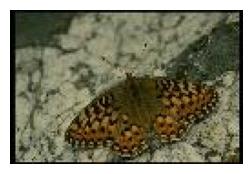

Top 10 results


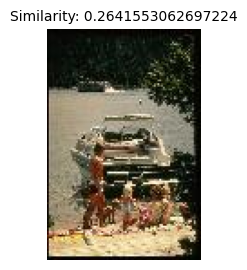

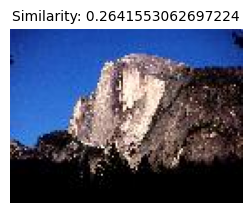

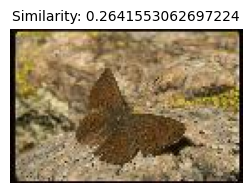

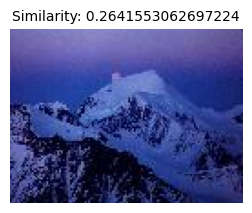

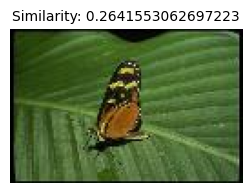

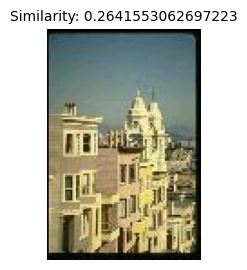

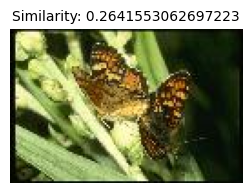

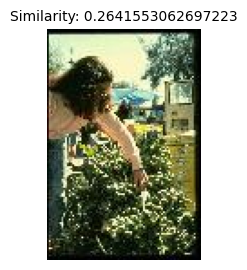

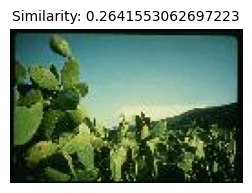

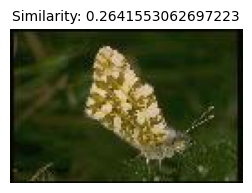

In [ ]:
import random

query_image_path = random.choice(image_filenames)
query_image = cv2.imread(os.path.join(dataset_dir, query_image_path), 1)
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
preprocessed_query_image = preprocess_query(query_image)
preprocessed_src_images = preprocess_images(src_images)

top_k = 10
ranked_list, scores = ranking(preprocessed_query_image, preprocessed_src_images, top_k)
print('Query Image')
plt.figure(figsize=(3, 3))
plt.imshow(query_image)
plt.axis('off')
plt.show()

print(f'Top {top_k} results')
for idx in range(len(ranked_list)):
    src_image_idx = ranked_list[idx]
    similarity_score = scores[idx]
    plt.figure(figsize=(3, 3))
    plt.imshow(src_images[src_image_idx])
    plt.title(f"Similarity: {similarity_score}", fontsize=10)
    plt.axis('off')
    plt.show()